# Word2Vec

1. Problem statement:
  - We have N_dict words to represent in a vectorial way
  - One-hot encoding explodes (N_dict dimensions)
  - Representations that contain semantic information are superrior

2. Word2Vec solutions:
  - Use real valued (unit) vectors
  - Use a constant emb_dim << N_dict dimensionality
  - Capture semantic information by describing each word by its most frequent usage
    - By constructing representations based on neighbouring words

3. Using neural networks for training Word2Vec
  - CBOW
  - Skip-gram

## Sources:

https://arxiv.org/pdf/1310.4546.pdf   
https://arxiv.org/pdf/1301.3781.pdf   
https://www.tensorflow.org/tutorials/text/word2vec

# Requirements:
- A large enough corpus
- GPU runtime

In [ ]:
!nvidia-smi

Wed Apr  5 22:20:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Download a larger text corpus
def download_from_drive(link, filename):
  id = link.split("/")[-2]
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={id}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={id}" -O {"/content/"+filename} && rm -rf /tmp/cookies.txt

download_from_drive("https://drive.google.com/file/d/1xnBd4cA2sz5geHwz4V6ldV7IwJwZffq7/view?usp=sharing", "200k.txt")


--2023-04-05 22:20:36--  https://docs.google.com/uc?export=download&confirm=t&id=1xnBd4cA2sz5geHwz4V6ldV7IwJwZffq7
Resolving docs.google.com (docs.google.com)... 173.194.69.101, 173.194.69.100, 173.194.69.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.69.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/r9tdpddpj04un5f6dvfkqcvgborl0ts1/1680733200000/02440328774490686871/*/1xnBd4cA2sz5geHwz4V6ldV7IwJwZffq7?e=download&uuid=2f2e0c93-3fd2-4d53-b394-9b6a81defd69 [following]
--2023-04-05 22:20:37--  https://doc-0s-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/r9tdpddpj04un5f6dvfkqcvgborl0ts1/1680733200000/02440328774490686871/*/1xnBd4cA2sz5geHwz4V6ldV7IwJwZffq7?e=download&uuid=2f2e0c93-3fd2-4d53-b394-9b6a81defd69
Resolving doc-0s-1k-docs.googleusercontent.com (doc-0s-1k-docs.googleusercontent.com)... 108.177.96.132, 

In [ ]:
with open("./200k.txt","r") as f:
  lines = f.readlines()

In [ ]:
len(lines)

2056711

In [ ]:
#Reducing dataset so it will fit into memory and labtime
lines = lines[:1000000]

In [ ]:
lines[0]

'By . Joel Christie . Oklahoma man Desmond Campbell was identified last week by police as wanted in at least seven assaults cases. Authorities linked him to 10 counts of sexual assault - including rape in the first degree and rape by instrumentation - as well as seven counts of burglary and six counts of robbery. A possible assault against an eight woman was pending, with all occurring between June 5 and June 29 in Tulsa. After naming the 30-year-old at a press conference last week, police said their suspect was actually in a critical condition at Saint Francis Hospital, according to 2NEWS. Karma?: Desmond Campbell, 30, was wanted over seven assaults on women in Tulsa, Oklahoma, when he crashed his car and died . The 30-year-old was wanted a total of 23 charges, including 10 sexual assault complaints, seven burglaries and six robberies . According to KJRH, Desmond Campbell, 30, was in critical condition and unresponsive following a car crash June 29 . Campbell’s car hit a light pole on

### Preprocessing

1. Sentence splitting
2. Stop word filtering and stemming
3. Building vocabulary with tf.Tokenizer

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
sents = []
for line in lines:
  sents += nltk.tokenize.sent_tokenize(line)

In [ ]:
len(sents)

3541571

In [ ]:
sents=sents[:1500000]

In [ ]:
sents[1000]

'The justices on Monday heard six separate appeals, which were consolidated into more than 100 minutes of often dense oral arguments.'

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(len(stop))
stop

179


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [ ]:
for i in range(len(sents)):
  sents[i] = " ".join([word for word in 
                       nltk.tokenize.word_tokenize(sents[i].lower()) 
                       if word not in stop]) 
  if i%100000==0:
    print(i)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000


In [ ]:
sents[1000]

'justices monday heard six separate appeals , consolidated 100 minutes often dense oral arguments .'

### Stemming to decrease vocabulary size (not always recommended in a real world scenario)

In [ ]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


In [ ]:
# Stemming
sents = [" ".join([stemmer.stem(word) for word in 
                   nltk.tokenize.word_tokenize(sent)]) for sent in sents]

In [ ]:
sents[1000]

'justic monday heard six separ appeal , consolid 100 minut often dens oral argument .'

In [ ]:
import tensorflow as tf
import numpy as np

### Assembling vocabulary and word counts

In [ ]:
num_words = 4096
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, 
                                                  oov_token="<OOV>")

In [ ]:
tokenizer.fit_on_texts(sents)

In [ ]:
print(len(tokenizer.word_index))
tokenizer.word_index

168271


{'<OOV>': 1,
 "'s": 2,
 'said': 3,
 "'": 4,
 '’': 5,
 'year': 6,
 'one': 7,
 'would': 8,
 'peopl': 9,
 'time': 10,
 'say': 11,
 'also': 12,
 '‘': 13,
 "n't": 14,
 'two': 15,
 'new': 16,
 'last': 17,
 'like': 18,
 'first': 19,
 'mr': 20,
 'told': 21,
 'day': 22,
 'could': 23,
 'polic': 24,
 'report': 25,
 'use': 26,
 'work': 27,
 'go': 28,
 'get': 29,
 'make': 30,
 'state': 31,
 'take': 32,
 'back': 33,
 'home': 34,
 'old': 35,
 'right': 36,
 'famili': 37,
 'show': 38,
 'call': 39,
 'world': 40,
 'want': 41,
 'three': 42,
 'week': 43,
 '“': 44,
 'includ': 45,
 '”': 46,
 'look': 47,
 'month': 48,
 '000': 49,
 'left': 50,
 'offic': 51,
 'made': 52,
 'found': 53,
 'come': 54,
 'even': 55,
 'may': 56,
 'mani': 57,
 'govern': 58,
 'live': 59,
 'us': 60,
 'way': 61,
 'help': 62,
 '1': 63,
 'presid': 64,
 'court': 65,
 'citi': 66,
 'countri': 67,
 'see': 68,
 'need': 69,
 'nation': 70,
 'play': 71,
 'know': 72,
 'think': 73,
 'hous': 74,
 'man': 75,
 'well': 76,
 'sinc': 77,
 'around': 78,
 'p

In [ ]:
vocabulary = dict(list(tokenizer.word_index.items())[:num_words+1])

In [ ]:
list(tokenizer.word_counts.items())[:100]

[('joel', 324),
 ('christi', 1200),
 ('oklahoma', 747),
 ('man', 19900),
 ('desmond', 65),
 ('campbel', 804),
 ('identifi', 4905),
 ('last', 40568),
 ('week', 26597),
 ('polic', 37911),
 ('want', 26960),
 ('least', 7943),
 ('seven', 6494),
 ('assault', 4826),
 ('case', 17900),
 ('author', 13227),
 ('link', 5054),
 ('10', 15054),
 ('count', 3522),
 ('sexual', 5699),
 ('includ', 26342),
 ('rape', 3392),
 ('first', 39452),
 ('degre', 2746),
 ('instrument', 786),
 ('well', 19716),
 ('burglari', 506),
 ('six', 11130),
 ('robberi', 922),
 ('possibl', 8957),
 ('eight', 5982),
 ('woman', 10780),
 ('pend', 692),
 ('occur', 3155),
 ('june', 6145),
 ('5', 12188),
 ('29', 3260),
 ('tulsa', 124),
 ('name', 13095),
 ('30', 9421),
 ('year', 96153),
 ('old', 29627),
 ('press', 7678),
 ('confer', 4064),
 ('said', 189053),
 ('suspect', 6105),
 ('actual', 5275),
 ('critic', 6651),
 ('condit', 7671),
 ('saint', 1013),
 ('franci', 1215),
 ('hospit', 13470),
 ('accord', 19095),
 ('2new', 3),
 ('karma', 36),

In [ ]:
data = tokenizer.texts_to_sequences(sents)

In [ ]:
data[0]

[]

# Subsampling

$P(w_i)$ - probability of discarding a sample    
$t$ - threshold   
$f(w_i)$ - frequency of the word


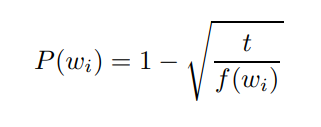

In [ ]:
vocab_freq = {}
num_all_tokens = 0
for word, tokencount in tokenizer.word_counts.items():
  num_all_tokens += tokencount

num_vocab_tokens = 0
for word, tokenid in vocabulary.items():
  if word == "<OOV>":
    continue
  vocab_freq[tokenid] = tokenizer.word_counts[word]/num_all_tokens
  num_vocab_tokens += tokenizer.word_counts[word]

# OOV token workaround: count all Vocab tokens occurences and subtract from all
vocab_freq[1] = (num_all_tokens-num_vocab_tokens)/num_all_tokens


In [ ]:
import matplotlib.pyplot as plt

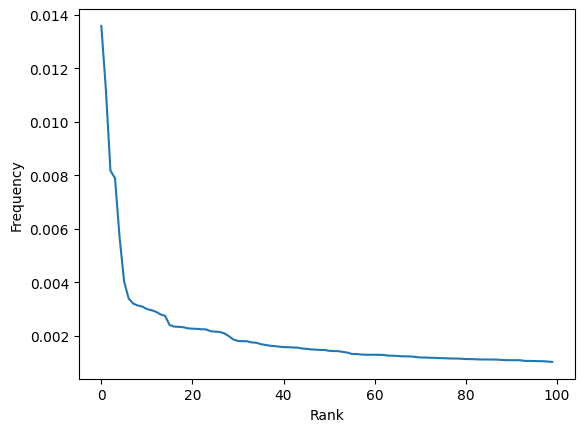

In [ ]:
plt.plot(list(vocab_freq.values())[:100])
plt.ylabel("Frequency")
plt.xlabel("Rank");

In [ ]:
def generate_discard_probability(frequency_dict, threshold=1e-5):
  discard_probability_dict = {}
  for token, freq in frequency_dict.items():
    discard_probability_dict[token] = 1-np.sqrt(threshold/freq)
  return discard_probability_dict

disc_dict = generate_discard_probability(vocab_freq, 1e-6) 

# Generate training couples

## Positive sample
- Context words in a specified distance (window size) from the target word are positive samples

<img src="https://1.bp.blogspot.com/-nZFc7P6o3Yc/XQo2cYPM_ZI/AAAAAAAABxM/XBqYSa06oyQ_sxQzPcgnUxb5msRwDrJrQCLcBGAs/s1600/image001.png">

## Skip-gram modelling
Goal: maximize the log-probability of context words given the target word
- $T$ is the number of tokens
- $c$ is the window size
- $w_t$ is the target word
- $w_{t+j}$ is a context word


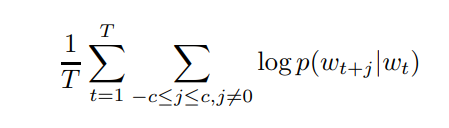




## Calculating log-probabilities

Using softmax in this case
- $w_O$ is the output word
- $w_I$ is the input word
- $W$ is the vocabulary size
- $v_x$ is the vectorial embedding of a given word $x$

Complexity ~ $\mathcal{O}(W)$


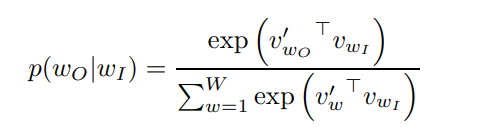

## Negative sampling
- Instead of calculating softmax for the whole vocabulary we use a low, fixed number of negative samples for each token
- A negative sample is a word not in the context window of the target word

In [ ]:
import random

def sample_skipgrams(sequences, vocab_size, window_size, num_neg_sample, discard_prob):
  contexts = []
  labels = []
  targets = []
  for sequence in sequences:
    for target in range(len(sequence)):
      # Discard token based on subsampling
      if random.random()<discard_prob[sequence[target]]:
        continue
      positivewords = []
      # Generate positive samples
      for w_idx in range(-window_size, window_size+1):
        if w_idx != 0 and (not target+w_idx<0) and \
                    (not target+w_idx>=len(sequence)):
          positivewords.append(sequence[target+w_idx])
      # Generate negative samples for each positive sample
      for pos in range(len(positivewords)):
        negativewords = []
        for neg in range(num_neg_sample):
          randword = random.randint(1,vocab_size)
          while randword in positivewords:
            randword = random.randint(1,vocab_size)
          negativewords.append(randword)
        targets.append(sequence[target])
        contexts.append([positivewords[pos]]+negativewords)
        labels.append([1]+[0]*len(negativewords))

  return np.array(targets, dtype=np.int64),np.array(contexts, dtype=np.int64),\
        np.array(labels, dtype=np.int64)


In [ ]:
neg_samples= 5
window_size = 3
targets, contexts, labels = sample_skipgrams(data, num_words, window_size, neg_samples, disc_dict)

Shorthand pre-written function with similar functionality:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/skipgrams

In [ ]:
contexts.shape

(4180313, 6)

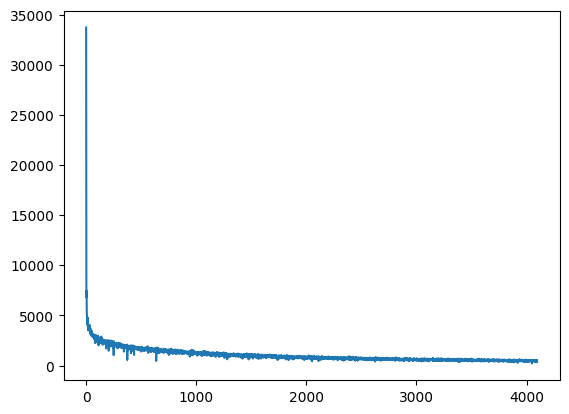

In [ ]:
idx, counts = np.unique(targets, return_counts=True)
plt.plot(idx, counts)

In [ ]:
print(targets[:3])
print(contexts[:3])
print(labels[:3])

[2370   97   97]
[[   1  872 2498 2549  591 2511]
 [ 404 3347 3658  812 1521 2763]
 [ 537 3206 3550  713 3734 3456]]
[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]


# Assembling a model
- $v_{w_t}$ and $v_{w_c}$ embedding should be constructed using TF Keras Embedding layers
- Dot-products should be calculated for all context-target pairs
- Softmax should be applied to the vector of dot-products
- Labels are 1 for a positive sample and 0 for a negative one
- Binary crossentropy can be used as a loss metric (we have binary labels)

In [ ]:
class SkipgramModel(tf.keras.models.Model):
  def __init__(self, vocab_size, embedding_size, num_neg_samples):
    super(SkipgramModel, self).__init__()
    self.context_emb = tf.keras.layers.Embedding(vocab_size, embedding_size, 
                                                 input_length=num_neg_samples+1, 
                                                 name="context_emb")
    self.target_emb = tf.keras.layers.Embedding(vocab_size, embedding_size, 
                                                input_length=1, 
                                                name="target_emb")
  
  def call(self, data):
    target, context = data
    v_targ, _ = tf.linalg.normalize(self.target_emb(target), axis=-1) # batch, emb_dim
    v_cont    = self.context_emb(context) # batch, num_neg_samp+1, emb_dim

    # dot product of the two matrices with the inner dimension of emb_dim
    # the input shapes are be and bne, the desired output shape is bn
    dot_prod = tf.einsum("be,bne->bn",v_targ,v_cont)

    return tf.nn.softmax(dot_prod,axis=-1)


In [ ]:
model = SkipgramModel(num_words, 64, neg_samples)

In [ ]:
model.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])

In [ ]:
model.fit([targets, contexts],labels, epochs=7, batch_size=8192, validation_split = 0.15, shuffle=True)

In [ ]:
weights = model.get_layer('target_emb').get_weights()[0]

NameError: ignored

### We could average or sum the two matrices as well

In [ ]:
weights.shape

(4096, 64)

In [ ]:
def getW2V(word):
  assert word.find(" ")<0
  id = tokenizer.texts_to_sequences([stemmer.stem(word.lower())])[0][0]
  return weights[id,:].flatten()/np.linalg.norm(weights[id,:].flatten())

In [ ]:
getW2V("king")

array([ 0.04306851,  0.04996744, -0.02657381,  0.1496954 ,  0.03875703,
       -0.08090428,  0.09052738,  0.05654401,  0.02985211, -0.05374721,
       -0.06229451,  0.01601284,  0.0858064 , -0.00509588, -0.03853964,
        0.23664828, -0.02230639, -0.12156384,  0.02146436,  0.02331606,
        0.0392754 , -0.08868923,  0.27166152,  0.27738172,  0.05781792,
        0.0273494 , -0.00501094, -0.20225924,  0.08398657, -0.14453782,
        0.12794608,  0.09583001,  0.04478685, -0.11706232, -0.15881874,
        0.08454146,  0.03658047, -0.07492401,  0.01205664,  0.13693662,
       -0.15768999,  0.00365687, -0.20460892,  0.19643576,  0.06990264,
        0.01067757,  0.16771573,  0.16316834,  0.12761612, -0.1628074 ,
       -0.25298107, -0.0541987 ,  0.02152021, -0.00969073, -0.05090966,
        0.12279128, -0.00090948, -0.23697338, -0.14820865,  0.22146258,
        0.2418284 , -0.0115151 , -0.08774617,  0.21189159], dtype=float32)

### Similarity and analogy measures

In [ ]:
def cos_sim(a, b):
  return np.dot(a,b)/np.linalg.norm(a)/np.linalg.norm(b)

In [ ]:
print(cos_sim(getW2V("cat"),getW2V("machine")))
print(cos_sim(getW2V("cat"),getW2V("dog")))

0.72237587
0.8593138


In [ ]:
vec = getW2V("king")-getW2V("man")+getW2V("woman")
vec /= np.linalg.norm(vec)
cos_sim(vec,getW2V("queen"))

0.8035637

In [ ]:
vec = getW2V("Madrid")-getW2V("Spain")+getW2V("France")
vec /= np.linalg.norm(vec)
cos_sim(vec,getW2V("Paris"))

0.71806943

In [ ]:
vec = getW2V("Madrid")-getW2V("Spain")+getW2V("Hungary")
vec /= np.linalg.norm(vec)
cos_sim(vec,getW2V("Paris"))

0.24399456

In [ ]:
vec = getW2V("winter")-getW2V("cold")+getW2V("warm")
vec /= np.linalg.norm(vec)
cos_sim(vec,getW2V("summer"))

0.7976838

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(weights.T)

PCA(n_components=2)

In [ ]:
pca.components_.shape

(2, 4096)

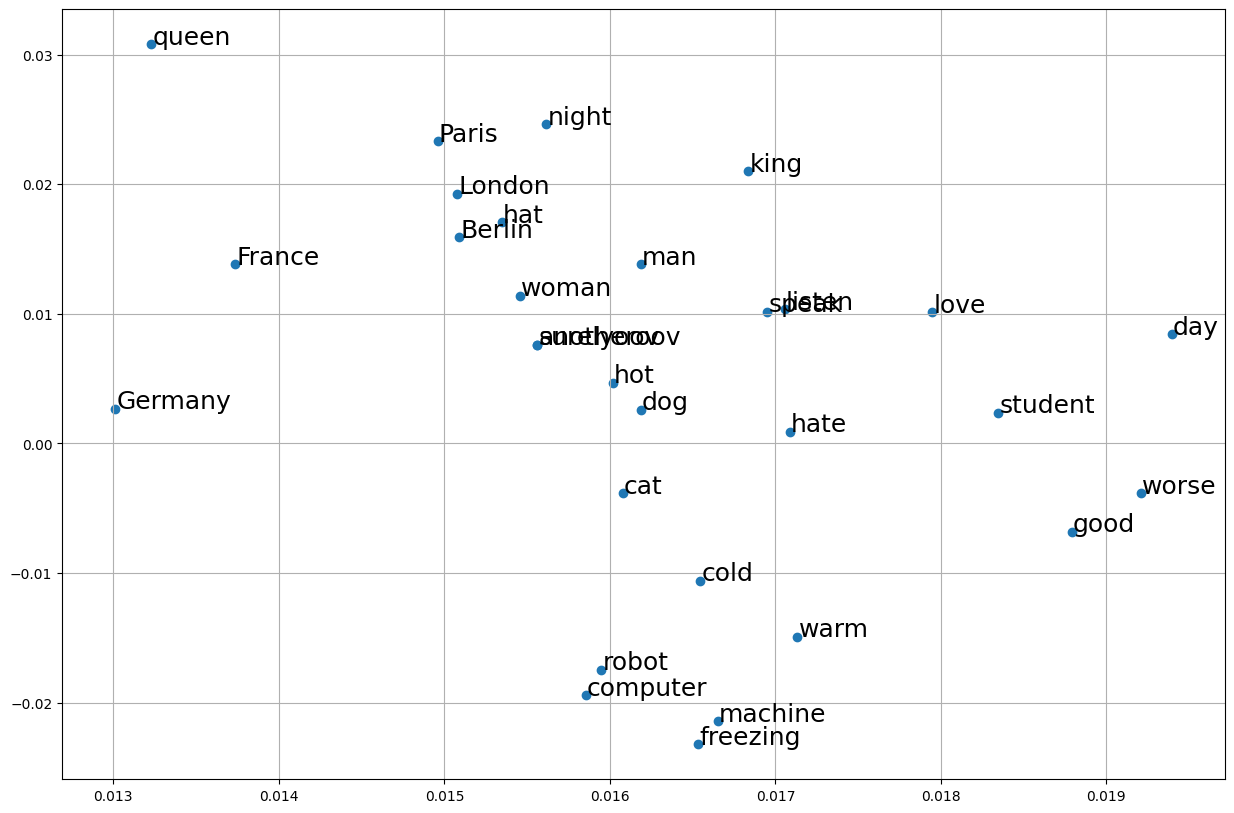

In [ ]:
words_to_plot=["king","queen","man","woman","Paris","France","Berlin","Germany","speak","listen","surelyoov","anotheroov",
               "warm","cold","hot","freezing","love","hate","hat","day","night","cat","dog",
               "computer","robot","machine","student","good","worse","London"]
ids_to_plot = [tokenizer.texts_to_sequences([stemmer.stem(word.lower())])[0][0] for word in words_to_plot]

plt.figure(figsize=(15,10))
ax = plt.axes()

ax.scatter(pca.components_[0,ids_to_plot],pca.components_[1,ids_to_plot])
for i, word in enumerate(words_to_plot):
    ax.annotate(word, (pca.components_[0,ids_to_plot][i]+8e-6, pca.components_[1,ids_to_plot][i]+8e-6),size=18)

plt.grid()

## Saving to Word2Vec format

<b>NOTE:</b> The process above is just an example, it contains optional steps, there are numerous enhancements that can be added to the word2vec training procedure, which might fit a specific use-case better than any methods presented here.

## Word2Vec format
- Space separated, decimal is a dot, encoding is UTF-8 (usually)
- Header: num_words n_dim
- Data row: word_string embedding_vector\n


In [ ]:
with open("./word2vec_lab.txt","w") as f:
  f.write(str(num_words)+" "+str(128)+"\n")
  for i in range(num_words):
    f.write(list(vocabulary.keys())[i]+" "+" ".join([str(w) for w in weights[0,:]])+"\n")

## Pre-packed Word Embedding Trainer Modules

1. Gensim - Word2Vec https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html   
2. Facebook AI Research - FastText Embedding https://fasttext.cc/docs/en/supervised-tutorial.html

- Here you specify training parameters and the corpus
- Execution of the above specified methods is automatic

### Building word embeddings can be topic-specific
- Eg.: sentiment analysis, domain-specific embedding (pharmacy, business, etc.)...

### Word embedding repository:
http://vectors.nlpl.eu/repository/